In [5]:
# Importing necessary libraries to unzip `tiny-imagenet-200.zip`
import os
import zipfile
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#import pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [6]:
#import custom modules
from models.cnn import SimpleCNN
from models.resnet18 import ResNet18

In [7]:
# Unzip the dataset
#with zipfile.ZipFile("tiny-imagenet-200.zip", 'r') as zip_ref:
#    zip_ref.extractall()

In [8]:
# Lets see the directory structure of tiny-imagenet-200
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        jpeg_files = [f for f in files if f.endswith('.JPEG')]
        if jpeg_files:  # if the list is not empty
            print('{}Number of JPEG files: {}'.format(subindent, len(jpeg_files)))
        for f in files:
            if f.endswith('.txt'):
                print('{}{}'.format(subindent, f))

list_files('tiny-imagenet-200')

tiny-imagenet-200/
    wnids.txt
    words.txt
    test/
        images/
            Number of JPEG files: 10000
    train/
        n01443537/
            n01443537_boxes.txt
            images/
                Number of JPEG files: 500
        n01629819/
            n01629819_boxes.txt
            images/
                Number of JPEG files: 500
        n01641577/
            n01641577_boxes.txt
            images/
                Number of JPEG files: 500
        n01644900/
            n01644900_boxes.txt
            images/
                Number of JPEG files: 500
        n01698640/
            n01698640_boxes.txt
            images/
                Number of JPEG files: 500
        n01742172/
            n01742172_boxes.txt
            images/
                Number of JPEG files: 500
        n01768244/
            n01768244_boxes.txt
            images/
                Number of JPEG files: 500
        n01770393/
            n01770393_boxes.txt
            images/
              

In [9]:
# Path and Files
path = './tiny-imagenet-200/train/'
wnid_labels = dict(line.strip().split('\t') for line in open('./tiny-imagenet-200/words.txt'))  # Corrected path
dirs = os.listdir(path)

# Read the wnids from wnids.txt into a set
with open('./tiny-imagenet-200/wnids.txt') as f:
    wnids = {line.strip() for line in f}

# Filter wnid_labels to only include the wnids in Tiny ImageNet
wnid_labels = {wnid: desc for wnid, desc in wnid_labels.items() if wnid in wnids}

len(wnid_labels) # We only want the mappings that are in tinynet

200

In [10]:
# Define the function to randomly sample n images
def rsample_images(n):
    """
    Sample n random images from the train directory along with their English wnid representations and bounding boxes.

    Args:
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    for _ in range(n):
        random_dir = random.choice(dirs)
        random_image = random.choice(os.listdir(os.path.join(path, random_dir, 'images')))
        box_data = [line.strip().split('\t') for line in open(os.path.join(path, random_dir, f"{random_dir}_boxes.txt"))]
        box_for_image = [box for box in box_data if box[0] == random_image][0]
        samples_with_boxes.append((random_dir, os.path.join(path, random_dir, 'images', random_image), box_for_image))

    return samples_with_boxes

In [11]:
# Define the function to sample n images by wordnet-id
def sample_images_by_wnid(wnid, n):
    """
    Sample 'n' images of a specific wnid from the train directory along with their English wnid representations and bounding boxes.

    Args:
    wnid (str): The wnid of the images to sample.
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    image_dir = os.path.join(path, wnid, 'images')
    box_data = [line.strip().split('\t') for line in open(os.path.join(path, wnid, f"{wnid}_boxes.txt"))]
    
    for image_name in os.listdir(image_dir)[:n]:
        box_for_image = [box for box in box_data if box[0] == image_name][0]
        samples_with_boxes.append((wnid, os.path.join(image_dir, image_name), box_for_image))

    return samples_with_boxes


In [12]:
# Define the function to display images
def display_images(samples_with_boxes):
    """
    Display images along with their English wnid representations and bounding boxes.

    Args:
    samples_with_boxes (List[Tuple]): A list of tuples where each tuple contains wnid, image path, and bounding box.

    Returns:
    None
    """
    n = len(samples_with_boxes)
    fig, axs = plt.subplots(n, 1, figsize=(2, 2*n))
    if n == 1:
        axs = [axs]
    for i, (wnid, img_path, box) in enumerate(samples_with_boxes):
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].title.set_text(wnid_labels[wnid])
        axs[i].title.set_fontsize(8)

        x, y, w, h = map(int, box[1:])
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)

        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

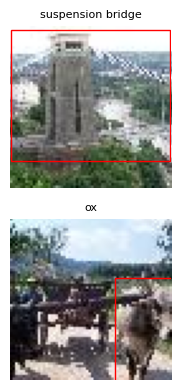

In [13]:
display_images(rsample_images(2))

In [14]:
#display_images(sample_images_by_wnid('n02099601',2))

In [15]:
# Here's how you can create a DataLoader for your dataset. Remember, this code won't run in this environment but you can use it as a template in your local environment:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

# Load Tiny ImageNet dataset
train_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/train', transform=transform)
val_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/val', transform=transform)



# Create data loaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [16]:
len(train_loader)

1000

In [17]:
# Inspect a batch from train_loader
train_images, train_labels = next(iter(train_loader))
print("Train images batch shape:", train_images.shape)
print("Train labels batch shape:", train_labels.shape)
print("Train images data type:", train_images.dtype)
print("Train labels data type:", train_labels.dtype)

# Inspect a batch from val_loader
val_images, val_labels = next(iter(val_loader))
print("Validation images batch shape:", val_images.shape)
print("Validation labels batch shape:", val_labels.shape)
print("Validation images data type:", val_images.dtype)
print("Validation labels data type:", val_labels.dtype)


Train images batch shape: torch.Size([100, 3, 64, 64])
Train labels batch shape: torch.Size([100])
Train images data type: torch.float32
Train labels data type: torch.int64
Validation images batch shape: torch.Size([100, 3, 64, 64])
Validation labels batch shape: torch.Size([100])
Validation images data type: torch.float32
Validation labels data type: torch.int64


In [18]:
def train_model(model, train_loader, batch_size, criterion, optimizer, num_epochs):
    model.to(device)
    model.train()  # Set the model to training mode
    total_step = len(train_loader)
    loss_list = []
    acc_list = []

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Run the forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Backprop and perform optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % batch_size == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, Accuracy: {100*(correct / total):.2f}%')

        print(f'End of Epoch [{epoch + 1}/{num_epochs}], Loss: {np.mean(loss_list):.4f}, Accuracy: {100*np.mean(acc_list):.2f}%')
        loss_list = []
        acc_list = []

def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():  # We don't need gradients for evaluation
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    print(f'Final Validation accuracy: {100 * correct / total}%, Final Validation loss: {total_loss / len(val_loader)}')

In [19]:
# Initialize a fresh cnn-model with Cross Entropy Loss
cnn_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer for our CNN
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 15
train_model(cnn_model, train_loader, batch_size, criterion, optimizer, num_epochs)

# Assume model is your trained model
torch.save(cnn_model.state_dict(), "./model_params/cnn_model_parameters.pth")

Epoch [1/15], Step [100/1000], Loss: 5.2885, Accuracy: 2.00%
Epoch [1/15], Step [200/1000], Loss: 5.2964, Accuracy: 0.00%
Epoch [1/15], Step [300/1000], Loss: 5.2927, Accuracy: 2.00%
Epoch [1/15], Step [400/1000], Loss: 5.2697, Accuracy: 1.00%
Epoch [1/15], Step [500/1000], Loss: 5.1990, Accuracy: 3.00%
Epoch [1/15], Step [600/1000], Loss: 5.1174, Accuracy: 4.00%
Epoch [1/15], Step [700/1000], Loss: 5.1210, Accuracy: 3.00%
Epoch [1/15], Step [800/1000], Loss: 4.9916, Accuracy: 1.00%
Epoch [1/15], Step [900/1000], Loss: 4.9562, Accuracy: 3.00%
Epoch [1/15], Step [1000/1000], Loss: 4.9190, Accuracy: 4.00%
End of Epoch [1/15], Loss: 5.1505, Accuracy: 1.60%
Epoch [2/15], Step [100/1000], Loss: 4.8282, Accuracy: 3.00%
Epoch [2/15], Step [200/1000], Loss: 4.7340, Accuracy: 6.00%
Epoch [2/15], Step [300/1000], Loss: 4.7570, Accuracy: 7.00%
Epoch [2/15], Step [400/1000], Loss: 4.6570, Accuracy: 6.00%
Epoch [2/15], Step [500/1000], Loss: 4.6718, Accuracy: 6.00%
Epoch [2/15], Step [600/1000], Lo

In [20]:
# Initialize a fresh cnn-model with Cross Entropy Loss
cnn_model_adam = SimpleCNN()
criterion = nn.CrossEntropyLoss()

# Use Adam as the optimizer for our CNN
optimizer = optim.Adam(cnn_model_adam.parameters(), lr=0.001)
num_epochs = 15
train_model(cnn_model_adam, train_loader, batch_size, criterion, optimizer, num_epochs) # optimizer changed to adam

# Assume model is your trained model
torch.save(cnn_model_adam.state_dict(), "./model_params/cnn_model_adam_parameters.pth")

Epoch [1/15], Step [100/1000], Loss: 5.1655, Accuracy: 0.00%
Epoch [1/15], Step [200/1000], Loss: 5.0332, Accuracy: 1.00%
Epoch [1/15], Step [300/1000], Loss: 4.9663, Accuracy: 3.00%
Epoch [1/15], Step [400/1000], Loss: 4.7321, Accuracy: 6.00%
Epoch [1/15], Step [500/1000], Loss: 4.5217, Accuracy: 7.00%
Epoch [1/15], Step [600/1000], Loss: 4.5853, Accuracy: 8.00%
Epoch [1/15], Step [700/1000], Loss: 4.7094, Accuracy: 8.00%
Epoch [1/15], Step [800/1000], Loss: 4.3737, Accuracy: 11.00%
Epoch [1/15], Step [900/1000], Loss: 4.1906, Accuracy: 11.00%
Epoch [1/15], Step [1000/1000], Loss: 4.4886, Accuracy: 7.00%
End of Epoch [1/15], Loss: 4.7417, Accuracy: 5.27%
Epoch [2/15], Step [100/1000], Loss: 4.1174, Accuracy: 10.00%
Epoch [2/15], Step [200/1000], Loss: 4.3427, Accuracy: 12.00%
Epoch [2/15], Step [300/1000], Loss: 3.8182, Accuracy: 15.00%
Epoch [2/15], Step [400/1000], Loss: 4.0701, Accuracy: 15.00%
Epoch [2/15], Step [500/1000], Loss: 4.2181, Accuracy: 11.00%
Epoch [2/15], Step [600/10

#### CNN Observations:
Notice how much faster `optim.Adam(lr=0.001)` converges at first compared to `optim.SGD(lr=0.01)`; however, each time `optim.Adam(lr=0.001)` seemed slow to reach similar accuracies that `optim.SGD(lr=0.01)` was making.

In [21]:
model = ResNet18()
#model.load_state_dict(torch.load("./model_params/model_parameters.pth")) # comment out to train fresh model

criterion = nn.CrossEntropyLoss()  # Common choice for of loss for classification problems
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Common choice of optimizer for CNNs

# Ensure we are on cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We are running on {device}.")
# Define number of epochs to train
num_epochs = 10  # Adjust as needed

# Call the training function
train_model(model, train_loader, batch_size, criterion, optimizer, num_epochs)

# Assume model is your trained model
torch.save(model.state_dict(), "./model_params/model_parameters.pth")


We are running on cuda.
Epoch [1/10], Step [100/1000], Loss: 4.9740, Accuracy: 7.00%
Epoch [1/10], Step [200/1000], Loss: 4.3723, Accuracy: 7.00%
Epoch [1/10], Step [300/1000], Loss: 4.3622, Accuracy: 10.00%
Epoch [1/10], Step [400/1000], Loss: 3.8685, Accuracy: 12.00%
Epoch [1/10], Step [500/1000], Loss: 3.8881, Accuracy: 11.00%
Epoch [1/10], Step [600/1000], Loss: 3.9094, Accuracy: 16.00%
Epoch [1/10], Step [700/1000], Loss: 3.7586, Accuracy: 18.00%
Epoch [1/10], Step [800/1000], Loss: 3.8022, Accuracy: 15.00%
Epoch [1/10], Step [900/1000], Loss: 3.6084, Accuracy: 16.00%
Epoch [1/10], Step [1000/1000], Loss: 3.7216, Accuracy: 19.00%
End of Epoch [1/10], Loss: 4.1651, Accuracy: 12.55%
Epoch [2/10], Step [100/1000], Loss: 3.3165, Accuracy: 20.00%
Epoch [2/10], Step [200/1000], Loss: 3.7506, Accuracy: 15.00%
Epoch [2/10], Step [300/1000], Loss: 3.1745, Accuracy: 27.00%
Epoch [2/10], Step [400/1000], Loss: 3.6888, Accuracy: 24.00%
Epoch [2/10], Step [500/1000], Loss: 3.2439, Accuracy: 25

#### CNN-Model w/ SGD

In [22]:
# Load the trained model parameters
cnn_model = SimpleCNN()
cnn_model.load_state_dict(torch.load("./model_params/cnn_model_parameters.pth"))

# Ensure we are on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model.to(device)

# Initialize the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Call the evaluation function
evaluate_model(cnn_model, val_loader, criterion, device)

Final Validation accuracy: 14.46%, Final Validation loss: 4.27637407541275


#### CNN-Model w/ Adam

In [23]:
# Load the trained model parameters
cnn_model = SimpleCNN()
cnn_model.load_state_dict(torch.load("./model_params/cnn_model_adam_parameters.pth"))

# Ensure we are on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model.to(device)

# Initialize the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Call the evaluation function
evaluate_model(cnn_model, val_loader, criterion, device)

Final Validation accuracy: 19.18%, Final Validation loss: 3.784330840110779


#### Resnet-18

In [24]:
# Load the trained model parameters
model = ResNet18()
model.load_state_dict(torch.load("./model_params/model_parameters.pth"))

# Ensure we are on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Call the evaluation function
evaluate_model(model, val_loader, criterion, device)

Final Validation accuracy: 40.75%, Final Validation loss: 2.8054053020477294


### Lets investigate the difference between train loss and val loss on ResNet18
##### Perhaps we can try to shuffle up the orientations of the images during the training process so the model never technically sees the same input twice?